In [1]:
#https://github.com/keras-team/keras/blob/master/examples/lstm_text_generation.py#L57

# https://medium.com/@curiousily/making-a-predictive-keyboard-using-recurrent-neural-networks-tensorflow-for-hackers-part-v-3f238d824218

#https://stackoverflow.com/questions/40331510/how-to-stack-multiple-lstm-in-keras

import numpy as np
np.random.seed(42)
import tensorflow as tf
tf.set_random_seed(42)
from keras.models import Sequential, load_model
from keras.layers import Dense, Activation
from keras.layers import LSTM, Dropout, Embedding
from keras.layers import TimeDistributed
from keras.layers.core import Dense, Activation, Dropout, RepeatVector
from keras.optimizers import RMSprop
import matplotlib.pyplot as plt
import pickle
import sys
import heapq
import seaborn as sns
from pylab import rcParams

%matplotlib inline

sns.set(style='whitegrid', palette='muted', font_scale=1.5)

rcParams['figure.figsize'] = 12, 5

/usr/local/lib/python2.7/dist-packages/h5py/__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
path = 'nietzsche.txt'
text = open(path).read().lower()
print('corpus length:', len(text))

('corpus length:', 600892)


In [3]:
chars = sorted(list(set(text)))
char_indices = dict((c, i) for i, c in enumerate(chars))
indices_char = dict((i, c) for i, c in enumerate(chars))


In [4]:
print('unique chars:', len(chars))

('unique chars:', 59)


In [5]:
SEQUENCE_LENGTH = 40
step = 3
sentences = []
next_chars = []
for i in range(0, len(text) - SEQUENCE_LENGTH, step):
    sentences.append(text[i: i + SEQUENCE_LENGTH])
    next_chars.append(text[i + SEQUENCE_LENGTH])
#print(f'num training examples: {len(sentences)}')

In [6]:
X = np.zeros((len(sentences), SEQUENCE_LENGTH, len(chars)), dtype=np.bool)
y = np.zeros((len(sentences), len(chars)), dtype=np.bool)
for i, sentence in enumerate(sentences):
    for t, char in enumerate(sentence):
        X[i, t, char_indices[char]] = 1
    y[i, char_indices[next_chars[i]]] = 1

In [7]:
sentences[100]

'skilled and unseemly methods for\nwinning'

In [8]:
next_chars[100]

' '

In [9]:
X[0][0]

array([False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
        True, False, False, False, False, False, False, False, False,
       False, False, False, False, False])

In [10]:
X.shape

(200284, 40, 59)

In [11]:
y.shape

(200284, 59)

#### Implement Stacked LSTMs in Keras

Each LSTMs memory cell requires a 3D input. When an LSTM processes one input sequence of time steps, each memory cell will output a single value for the whole sequence as a 2D array.

LSTM Layer with 128 neurons




In [14]:
# Add additional emdedding layer at starting 

#max_features = 20000

model = Sequential()
model.add(LSTM(128, input_shape=(SEQUENCE_LENGTH, len(chars))))
model.add(Dense(len(chars)))
model.add(Activation('softmax'))

# Need to work on embedding & LSTM layer

#model.add(Embedding(vocab_size, 8, input_length=max_length))
#model.add(LSTM(128, input_shape=(SEQUENCE_LENGTH, len(chars)), return_sequences=True))
#model.add(LSTM(128, return_sequences=True))
#model.add(Dropout(0.2))
#model.add(Dense(len(chars)))
#model.add(Dropout(0.2))

In [15]:
optimizer = RMSprop(lr=0.01)
model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])
history = model.fit(X, y, validation_split=0.05, batch_size=128, epochs=20, shuffle=True).history

Train on 190269 samples, validate on 10015 samples
Epoch 1/20
190269/190269 [==============================] - 139s - loss: 2.0024 - acc: 0.4157 - val_loss: 1.6749 - val_acc: 0.4984
Epoch 2/20
190269/190269 [==============================] - 136s - loss: 1.6517 - acc: 0.5105 - val_loss: 1.5579 - val_acc: 0.5335
Epoch 3/20
190269/190269 [==============================] - 136s - loss: 1.5589 - acc: 0.5355 - val_loss: 1.5016 - val_acc: 0.5483
Epoch 4/20
190269/190269 [==============================] - 136s - loss: 1.5144 - acc: 0.5479 - val_loss: 1.4866 - val_acc: 0.5556
Epoch 5/20
190269/190269 [==============================] - 137s - loss: 1.4838 - acc: 0.5548 - val_loss: 1.4899 - val_acc: 0.5542
Epoch 6/20
190269/190269 [==============================] - 138s - loss: 1.4636 - acc: 0.5611 - val_loss: 1.4841 - val_acc: 0.5625
Epoch 7/20
190269/190269 [==============================] - 139s - loss: 1.4487 - acc: 0.5646 - val_loss: 1.4721 - val_acc: 0.5597
Epoch 8/20
190269/190269 [======

In [16]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_2 (LSTM)                (None, 128)               96256     
_________________________________________________________________
dense_2 (Dense)              (None, 59)                7611      
_________________________________________________________________
activation_2 (Activation)    (None, 59)                0         
Total params: 103,867
Trainable params: 103,867
Non-trainable params: 0
_________________________________________________________________


In [17]:
# Save Keras Model

model.save('keras_model.h5')
pickle.dump(history, open("history.p", "wb"))


#h5 = based model
#h6 = 128, 64, 32 LSTM
#h7 = 128,128,128 LSTM

#model.save('keras_model.h7')
#pickle.dump(history, open("history.p", "wb"))

In [18]:
model = load_model('keras_model.h5')
history = pickle.load(open("history.p", "rb"))

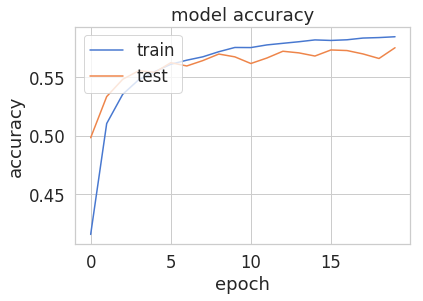

In [19]:
plt.plot(history['acc'])
plt.plot(history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left');

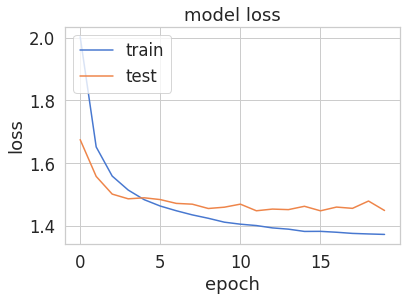

In [20]:
plt.plot(history['loss'])
plt.plot(history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left');

In [21]:
def prepare_input(text):
    x = np.zeros((1, SEQUENCE_LENGTH, len(chars)))
    for t, char in enumerate(text):
        x[0, t, char_indices[char]] = 1.
        
    return x

In [22]:
prepare_input("This is an example of input for our LSTM".lower())

array([[[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]]])

In [23]:
def sample(preds, top_n=3):
    preds = np.asarray(preds).astype('float64')
    preds = np.log(preds)
    exp_preds = np.exp(preds)
    preds = exp_preds / np.sum(exp_preds)
    
    return heapq.nlargest(top_n, range(len(preds)), preds.take)

In [24]:
def predict_completion(text):
    original_text = text
    generated = text
    completion = ''
    while True:
        x = prepare_input(text)
        preds = model.predict(x, verbose=0)[0]
        next_index = sample(preds, top_n=1)[0]
        next_char = indices_char[next_index]
        text = text[1:] + next_char
        completion += next_char
        
        if len(original_text + completion) + 2 > len(original_text) and next_char == ' ':
            return completion

In [25]:
def predict_completions(text, n=3):
    x = prepare_input(text)
    preds = model.predict(x, verbose=0)[0]
    next_indices = sample(preds, n)
    return [indices_char[idx] + predict_completion(text[1:] + indices_char[idx]) for idx in next_indices]

In [26]:
quotes = [
    "once by means of Jesuitism, and the second time by means of democratic enlightenment",
    "That which does not kill us makes us stronger.",
    "I'm not upset that you lied to me, I'm upset that from now on I can't believe you.",
    "And those who were seen dancing were thought to be insane by those who could not hear the music.",
    " How malicious philosophers can be! I know of nothing",
    "To be sure, in the case of scholars, in the case of really scientific men, it may be otherwise"
]

In [27]:
#for q in quotes:
#    seq = q[:40].lower()
#    print(seq)
#    print(predict_completions(seq, 5))
#    print()

In [31]:
for q in quotes:
    seq = q[:40].lower()
    print(seq)
    print(predict_completions(seq, 3))
    print()

once by means of jesuitism, and the seco
['tom ', 'ist ', 'nd ']
()
that which does not kill us makes us str
['iving ', 'ength ', 'ong ']
()
i'm not upset that you lied to me, i'm u
['nderstand ', 'se ', 'lling ']
()
and those who were seen dancing were tho
['ught ', 'se ', 'rt ']
()
 how malicious philosophers can be! i kn
['ownad ', 'ews ', 'aclish ']
()
to be sure, in the case of scholars, in 
['the ', 'an ', 'so ']
()


In [85]:
#https://stats.stackexchange.com/questions/200894/keras-lstm-need-for-a-final-dense-layer

The attention mechanism to overcome the limitation that allows the network to learn where to pay attention in the input sequence for each item in the output sequence.

https://machinelearningmastery.com/attention-long-short-term-memory-recurrent-neural-networks/
